In [1]:
import os
import torch
from torch.cuda.amp import autocast, GradScaler
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import copy
import random
import multiprocessing as mp
from torch_geometric.data import HeteroData
import torch
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import DataLoader  # For loading graphs in batches
from torch_geometric.utils import negative_sampling  # For handling link prediction tasks
from torch_geometric.utils import to_undirected
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

### Preliminaries:

In [2]:
# Load node data from csv
s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/s_emb_full_183.csv', index_col=0)
p_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/Other/tp_only_12301.csv', index_col=0)


In [3]:
# Load edge data from csv
tp_s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/distributed_combined_tp_s_edges_13340.csv')


In [4]:
tp_s_df

,source,target,label
0,Q1CR30,CHEBI:30616,1
1,Q2A1I2,CHEBI:30616,1
2,O67337,CHEBI:132124,1
3,B1MPH4,CHEBI:132124,1
4,Q6HP89,CHEBI:30616,1
...,...,...,...
26675,Q3JC24,CHEBI:456216,0
26676,B2U7R1,CHEBI:30616,0
26677,B2VIV5,CHEBI:15378,0
26678,P0C323,CHEBI:132124,0


In [5]:
# Load device of available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    device = torch.device("cuda:0")
    print(device)
    

cuda:0


In [6]:
tp_s_df

,source,target,label
0,Q1CR30,CHEBI:30616,1
1,Q2A1I2,CHEBI:30616,1
2,O67337,CHEBI:132124,1
3,B1MPH4,CHEBI:132124,1
4,Q6HP89,CHEBI:30616,1
...,...,...,...
26675,Q3JC24,CHEBI:456216,0
26676,B2U7R1,CHEBI:30616,0
26677,B2VIV5,CHEBI:15378,0
26678,P0C323,CHEBI:132124,0


### Function Definitions:

In [7]:
# Function to get the current date and time for the file name and log
def get_timestamp():
    return datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

In [8]:
# Inspect and clean the data, converts non-numeric columns to numeric and fills NaN values with 0
def inspect_and_clean(df):
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    print(f"Non-numeric columns: {non_numeric_columns}")
    if len(non_numeric_columns) > 0:
        df[non_numeric_columns] = df[non_numeric_columns].apply(pd.to_numeric, errors='coerce')
    df = df.fillna(0)
    return df


In [9]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [10]:
def apply_correct_mapping(df, source_mapping, target_mapping):
    # Apply the mappings to 'source' and 'target'
    df['mapped_source'] = df['source'].map(source_mapping)
    df['mapped_target'] = df['target'].map(target_mapping)

    # Identify rows where mapping failed (NaN values)
    unmapped_sources = df[df['mapped_source'].isna()]['source'].unique()
    unmapped_targets = df[df['mapped_target'].isna()]['target'].unique()

    # Log or print unmapped elements
    if len(unmapped_sources) > 0:
        print(f"Unmapped sources: {unmapped_sources}")
    if len(unmapped_targets) > 0:
        print(f"Unmapped targets: {unmapped_targets}")

    # Remove rows where mapping failed (NaN values)
    df.dropna(subset=['mapped_source', 'mapped_target'], inplace=True)

    # Replace original 'source' and 'target' with mapped values and drop the extra columns
    df['source'] = df['mapped_source']
    df['target'] = df['mapped_target']
    df.drop(columns=['mapped_source', 'mapped_target'], inplace=True)
    
    return df


### Code to manipulate data:

In [11]:
set_seed(42)


In [12]:
s_df = inspect_and_clean(s_df)
p_df = inspect_and_clean(p_df)


Non-numeric columns: Index([], dtype='object')
Non-numeric columns: Index([], dtype='object')


In [13]:
# Convert features to numpy arrays
s_features = s_df.values
p_features = p_df.values


In [14]:
# Check the shape of the features
print(f"Shape of s_features: {s_features.shape}")
print(f"Shape of p_features: {p_features.shape}")


Shape of s_features: (183, 1536)
Shape of p_features: (12301, 2048)


In [15]:
# Create separate mappings
protein_mapping = {node_id: i for i, node_id in enumerate(p_df.index)}
substrate_mapping = {node_id: i for i, node_id in enumerate(s_df.index)}


In [16]:
# Apply mappings to the full edge DataFrames before splitting
tp_s_df = apply_correct_mapping(tp_s_df, protein_mapping, substrate_mapping)


In [17]:
tp_s_df

,source,target,label
0,6048,0,1
1,6389,0,1
2,4380,63,1
3,3165,63,1
4,8328,0,1
...,...,...,...
26675,7165,18,0
26676,3351,0,0
26677,3375,19,0
26678,4590,63,0


In [18]:
# Converting the features to tensors (first convert to numpy arrays)
s_np = s_df.values
p_np = p_df.values

s_features_tensor = torch.tensor(s_np, dtype=torch.float).to(device)
p_features_tensor = torch.tensor(p_np, dtype=torch.float).to(device)


In [19]:
p_features_tensor

tensor([[ 0.0171, -0.0576, -0.0224,  ...,  0.3624, -0.1807,  0.1883],
        [-0.0125, -0.0156, -0.0371,  ...,  0.4206, -0.2489,  0.1974],
        [ 0.0028, -0.0836, -0.0325,  ...,  0.3974, -0.2052,  0.1842],
        ...,
        [ 0.0979, -0.0349,  0.0161,  ...,  0.4393, -0.1220,  0.1718],
        [ 0.0939, -0.1774,  0.2202,  ...,  0.4017, -0.1780,  0.1699],
        [ 0.0565, -0.0809,  0.1186,  ...,  0.3937, -0.1902,  0.1530]],
       device='cuda:0')

In [20]:
s_features_tensor

tensor([[ 0.4558,  0.2683, -0.3065,  ..., -0.3660, -0.8484, -0.2447],
        [ 0.6155,  0.1821, -0.1572,  ...,  0.0450, -0.3862, -0.4749],
        [ 0.5064,  0.4006,  0.0640,  ..., -0.5685, -0.8873, -0.2104],
        ...,
        [ 0.6212,  0.5304, -0.4603,  ..., -0.2120,  0.0052, -0.5082],
        [-0.1077,  0.3367, -0.0385,  ...,  0.0214, -0.0697, -0.3905],
        [ 0.4057, -0.2626, -0.5516,  ..., -0.1872, -0.2486, -0.3938]],
       device='cuda:0')

In [21]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming tp_s_df['source'] and tp_s_df['target'] contain valid mapped indices

# Convert the source and target columns to tensors
protein_indices = torch.tensor(tp_s_df['source'].values, dtype=torch.long).to(p_features_tensor.device)
substrate_indices = torch.tensor(tp_s_df['target'].values, dtype=torch.long).to(s_features_tensor.device)

# Index the protein and substrate feature tensors
p_features_tensor_mapped = p_features_tensor[protein_indices]
s_features_tensor_mapped = s_features_tensor[substrate_indices]

# Convert labels to tensor
labels_tensor = torch.tensor(tp_s_df['label'].values, dtype=torch.float32).to(p_features_tensor.device)

# # Create a TensorDataset
# dataset = TensorDataset(p_features_tensor_mapped, s_features_tensor_mapped, labels_tensor)

# # Split the dataset into training (60%), validation (20%), and test (20%) sets
# train_val_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)  # 80% train+val, 20% test
# train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)  # 60% train, 20% val

# # Create DataLoaders for training, validation, and test sets
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)  # No shuffling for validation
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)  # No shuffling for test set

# # Check the first batch of data from the training loader
# for batch in train_loader:
#     p_features, s_features, labels = batch
#     print(p_features)
#     print(s_features)
#     print(labels)
#     break

# Add protein and substrate indices to the TensorDataset
dataset = TensorDataset(p_features_tensor_mapped, s_features_tensor_mapped, labels_tensor)

# Split the dataset into training (60%), validation (20%), and test (20%) sets
train_val_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)  # 80% train+val, 20% test
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)  # 60% train, 20% val

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)  # No shuffling for validation
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)  # No shuffling for test set

# # Check the first batch of data from the test loader to extract protein and substrate indices
# for batch in test_loader:
#     p_features, s_features, labels, protein_ids_batch, substrate_ids_batch = batch
#     print("Protein Indices in Test Batch:", protein_ids_batch)
#     print("Substrate Indices in Test Batch:", substrate_ids_batch)



In [22]:
import torch

# Initialize lists to hold validation labels
val_labels = []

# Iterate through val_loader to collect all validation labels
for batch in val_loader:
    # Assuming the labels are the 3rd item in the dataset (p_features_tensor_mapped, s_features_tensor_mapped, labels_tensor)
    _, _, labels = batch  # Extract labels from the batch
    val_labels.append(labels)

# Concatenate all batches into a single tensor
val_labels = torch.cat(val_labels)

# Count the number of positive (1) and negative (0) labels
num_positives = (val_labels == 1).sum().item()  # Count positive labels
num_negatives = (val_labels == 0).sum().item()  # Count negative labels

# Calculate the class distribution percentage
total_samples = len(val_labels)
positive_percentage = (num_positives / total_samples) * 100
negative_percentage = (num_negatives / total_samples) * 100

# Display the results
print(f"Number of Positive samples: {num_positives}")
print(f"Number of Negative samples: {num_negatives}")
print(f"Positive samples percentage: {positive_percentage:.2f}%")
print(f"Negative samples percentage: {negative_percentage:.2f}%")


Number of Positive samples: 2682
Number of Negative samples: 2654
Positive samples percentage: 50.26%
Negative samples percentage: 49.74%


In [23]:
len(protein_indices)

26680

In [24]:
# from sklearn.model_selection import train_test_split
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# # Assuming tp_s_df['source'], tp_s_df['target'], and tp_s_df['label'] are valid

# # Step 1: Split off 20% for a naive test set (this is the first step before any other splits)
# tp_s_train_val_df, tp_s_test_df = train_test_split(tp_s_df, test_size=0.2, random_state=42)

# # Step 2: Prepare the naive test set (20% held out)
# test_protein_indices = torch.tensor(tp_s_test_df['source'].values, dtype=torch.long).to(p_features_tensor.device)
# test_substrate_indices = torch.tensor(tp_s_test_df['target'].values, dtype=torch.long).to(s_features_tensor.device)

# test_p_features_tensor_mapped = p_features_tensor[test_protein_indices]
# test_s_features_tensor_mapped = s_features_tensor[test_substrate_indices]

# test_labels_tensor = torch.tensor(tp_s_test_df['label'].values, dtype=torch.float32).to(p_features_tensor.device)

# # Create a TensorDataset and DataLoader for the naive test set
# test_dataset = TensorDataset(test_p_features_tensor_mapped, test_s_features_tensor_mapped, test_labels_tensor)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Step 3: Now split the remaining 80% into training (60%) and validation (20%)
# protein_indices_train_val = torch.tensor(tp_s_train_val_df['source'].values, dtype=torch.long).to(p_features_tensor.device)
# substrate_indices_train_val = torch.tensor(tp_s_train_val_df['target'].values, dtype=torch.long).to(s_features_tensor.device)

# p_features_tensor_mapped_train_val = p_features_tensor[protein_indices_train_val]
# s_features_tensor_mapped_train_val = s_features_tensor[substrate_indices_train_val]
# labels_tensor_train_val = torch.tensor(tp_s_train_val_df['label'].values, dtype=torch.float32).to(p_features_tensor.device)

# # Create the TensorDataset for training and validation
# train_val_dataset = TensorDataset(p_features_tensor_mapped_train_val, s_features_tensor_mapped_train_val, labels_tensor_train_val)

# # Step 4: Split the remaining 80% into 60% training and 20% validation
# train_data, val_data = train_test_split(train_val_dataset, test_size=0.25, random_state=42)  # 60% train, 20% val

# # Step 5: Create DataLoaders for training and validation
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [25]:
# import torch

# # Assuming tp_s_df has already been mapped (with 'source', 'target', and 'label' columns)

# # Step 1: Shuffle the dataset to ensure even distribution
# tp_s_df = tp_s_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Step 2: Calculate the split index for 20%
# split_index = int(len(tp_s_df) * 0.8)

# # Step 3: Split the dataset into 80% for training/validation and 20% for testing
# train_val_df = tp_s_df[:split_index]
# test_df = tp_s_df[split_index:]

# # Step 4: Convert the train/validation and test sets into PyTorch tensors

# # For training/validation set
# train_protein_indices = torch.tensor(train_val_df['source'].values, dtype=torch.long).to(p_features_tensor.device)
# train_substrate_indices = torch.tensor(train_val_df['target'].values, dtype=torch.long).to(s_features_tensor.device)

# train_p_features_tensor_mapped = p_features_tensor[train_protein_indices]
# train_s_features_tensor_mapped = s_features_tensor[train_substrate_indices]
# train_labels_tensor = torch.tensor(train_val_df['label'].values, dtype=torch.float32).to(p_features_tensor.device)

# # Create TensorDataset for training/validation
# train_val_dataset = TensorDataset(train_p_features_tensor_mapped, train_s_features_tensor_mapped, train_labels_tensor)

# # For test set
# test_protein_indices = torch.tensor(test_df['source'].values, dtype=torch.long).to(p_features_tensor.device)
# test_substrate_indices = torch.tensor(test_df['target'].values, dtype=torch.long).to(s_features_tensor.device)

# test_p_features_tensor_mapped = p_features_tensor[test_protein_indices]
# test_s_features_tensor_mapped = s_features_tensor[test_substrate_indices]
# test_labels_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32).to(p_features_tensor.device)

# # Create TensorDataset for testing
# test_dataset = TensorDataset(test_p_features_tensor_mapped, test_s_features_tensor_mapped, test_labels_tensor)

# # Step 5: Create DataLoaders for training/validation and test sets
# train_loader = DataLoader(train_val_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NonGraphModel(nn.Module):
    def __init__(self, protein_input_dim, substrate_input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(NonGraphModel, self).__init__()

        # Transformation layers to match input dimensions
        self.transform_p = nn.Linear(protein_input_dim, hidden_dim)  # Protein: 2048 -> 128
        self.transform_s = nn.Linear(substrate_input_dim, hidden_dim)  # Substrate: 1536 -> 128

        # Additional fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # Combine protein + substrate, then reduce dimension
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, p_features, s_features):
        # Apply transformations to ensure both node types have the same dimensionality
        p_transformed = self.transform_p(p_features)  # Protein features: 2048 -> 128
        s_transformed = self.transform_s(s_features)  # Substrate features: 1536 -> 128

        # Normalize the transformed features
        p_transformed = (p_transformed - p_transformed.mean(dim=0)) / p_transformed.std(dim=0)
        s_transformed = (s_transformed - s_transformed.mean(dim=0)) / s_transformed.std(dim=0)

        # Concatenate the transformed protein and substrate features
        combined_features = torch.cat([p_transformed, s_transformed], dim=1)  # Concatenating along feature dimension

        # Pass through fully connected layers
        out = F.relu(self.fc1(combined_features))
        out = self.dropout(out)  # Apply dropout after the first layer

        out = F.relu(self.fc2(out))
        out = self.dropout(out)

        out = self.fc3(out)  # Output layer
        return out


In [27]:
# Initialize model, optimizer, and loss function
num_epochs = 20
protein_input_dim = 2048
substrate_input_dim = 1536
hidden_dim = 128
output_dim = 1  # Binary classification (interaction or no interaction)
dropout_prob = 0.5

model = NonGraphModel(protein_input_dim, substrate_input_dim, hidden_dim, output_dim, dropout_prob).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()  # Binary classification loss


In [29]:
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# Define the evaluate function
def evaluate(model, val_loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for p_features, s_features, labels in val_loader:
            p_features, s_features, labels = p_features.to(device), s_features.to(device), labels.to(device)
            outputs = model(p_features, s_features)
            loss = torch.nn.BCEWithLogitsLoss()(outputs.squeeze(), labels)
            total_loss += loss.item()

            # Apply sigmoid to get probabilities and collect outputs
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Calculate average loss
    avg_loss = total_loss / len(val_loader)

    # Concatenate all outputs and labels from batches
    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)

    # Binarize the outputs using a threshold of 0.5 for binary classification
    all_preds = (all_outputs > 0.5).astype(int)

    # Calculate metrics
    auc = roc_auc_score(all_labels, all_outputs)  # AUC Score
    precision = precision_score(all_labels, all_preds)  # Precision
    recall = recall_score(all_labels, all_preds)  # Recall
    f1 = f1_score(all_labels, all_preds)  # F1 Score

    return avg_loss, auc, precision, recall, f1


import matplotlib.pyplot as plt

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store fold performance
fold_performance = []
metrics_history = {
    "train_loss": [],
    "val_loss": [],
    "val_auc": [],
    "val_precision": [],
    "val_recall": [],
    "val_f1": []
}

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(tp_s_df)):
    print(f"\nFold {fold + 1}\n" + "-"*20)

    # Split the dataset into training and validation based on the indices
    train_data = tp_s_df.iloc[train_idx]
    val_data = tp_s_df.iloc[val_idx]

    # Map protein and substrate indices to their respective features
    train_protein_indices = torch.tensor(train_data['source'].values, dtype=torch.long).to(p_features_tensor.device)
    train_substrate_indices = torch.tensor(train_data['target'].values, dtype=torch.long).to(s_features_tensor.device)

    val_protein_indices = torch.tensor(val_data['source'].values, dtype=torch.long).to(p_features_tensor.device)
    val_substrate_indices = torch.tensor(val_data['target'].values, dtype=torch.long).to(s_features_tensor.device)

    # Index the protein and substrate feature tensors for training and validation
    p_features_tensor_mapped_train = p_features_tensor[train_protein_indices]
    s_features_tensor_mapped_train = s_features_tensor[train_substrate_indices]

    p_features_tensor_mapped_val = p_features_tensor[val_protein_indices]
    s_features_tensor_mapped_val = s_features_tensor[val_substrate_indices]

    # Convert labels to tensor
    train_labels_tensor = torch.tensor(train_data['label'].values, dtype=torch.float32).to(p_features_tensor.device)
    val_labels_tensor = torch.tensor(val_data['label'].values, dtype=torch.float32).to(p_features_tensor.device)

    # Create TensorDataset for training and validation
    train_dataset = TensorDataset(p_features_tensor_mapped_train, s_features_tensor_mapped_train, train_labels_tensor)
    val_dataset = TensorDataset(p_features_tensor_mapped_val, s_features_tensor_mapped_val, val_labels_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Reset model, optimizer, and loss function for each fold
    model = NonGraphModel(protein_input_dim=2048, substrate_input_dim=1536, hidden_dim=128, output_dim=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Training loop for each fold
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for p_features, s_features, labels in train_loader:
            p_features, s_features, labels = p_features.to(device), s_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(p_features, s_features)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        # Evaluate on validation set
        val_loss, val_auc, val_precision, val_recall, val_f1 = evaluate(model, val_loader)

        # Store metrics for this epoch
        metrics_history["train_loss"].append(avg_train_loss)
        metrics_history["val_loss"].append(val_loss)
        metrics_history["val_auc"].append(val_auc)
        metrics_history["val_precision"].append(val_precision)
        metrics_history["val_recall"].append(val_recall)
        metrics_history["val_f1"].append(val_f1)

        # Print fold and epoch performance
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val AUC: {val_auc:.4f}, Precision: {val_precision:.4f}, "
              f"Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

    # Store fold performance metrics
    fold_performance.append((val_loss, val_auc, val_precision, val_recall, val_f1))

# After all folds, average the performance
avg_val_loss = sum([fp[0] for fp in fold_performance]) / len(fold_performance)
avg_val_auc = sum([fp[1] for fp in fold_performance]) / len(fold_performance)
avg_val_precision = sum([fp[2] for fp in fold_performance]) / len(fold_performance)
avg_val_recall = sum([fp[3] for fp in fold_performance]) / len(fold_performance)
avg_val_f1 = sum([fp[4] for fp in fold_performance]) / len(fold_performance)

# Print average performance across folds
print(f"\nAverage Validation Metrics across folds:")
print(f"Avg Loss: {avg_val_loss:.4f}, Avg AUC: {avg_val_auc:.4f}, "
      f"Avg Precision: {avg_val_precision:.4f}, Avg Recall: {avg_val_recall:.4f}, Avg F1 Score: {avg_val_f1:.4f}")




Fold 1
--------------------
Fold 1, Epoch 1, Train Loss: 0.3685, Val Loss: 0.1182, Val AUC: 0.9932, Precision: 0.9368, Recall: 0.9870, F1 Score: 0.9612
Fold 1, Epoch 2, Train Loss: 0.1392, Val Loss: 0.0707, Val AUC: 0.9969, Precision: 0.9566, Recall: 0.9929, F1 Score: 0.9745
Fold 1, Epoch 3, Train Loss: 0.1005, Val Loss: 0.0563, Val AUC: 0.9979, Precision: 0.9664, Recall: 0.9959, F1 Score: 0.9810
Fold 1, Epoch 4, Train Loss: 0.0834, Val Loss: 0.0491, Val AUC: 0.9983, Precision: 0.9724, Recall: 0.9940, F1 Score: 0.9831
Fold 1, Epoch 5, Train Loss: 0.0716, Val Loss: 0.0448, Val AUC: 0.9987, Precision: 0.9727, Recall: 0.9929, F1 Score: 0.9827
Fold 1, Epoch 6, Train Loss: 0.0699, Val Loss: 0.0412, Val AUC: 0.9988, Precision: 0.9756, Recall: 0.9959, F1 Score: 0.9856
Fold 1, Epoch 7, Train Loss: 0.0577, Val Loss: 0.0353, Val AUC: 0.9990, Precision: 0.9810, Recall: 0.9967, F1 Score: 0.9887
Fold 1, Epoch 8, Train Loss: 0.0565, Val Loss: 0.0362, Val AUC: 0.9990, Precision: 0.9816, Recall: 0.99

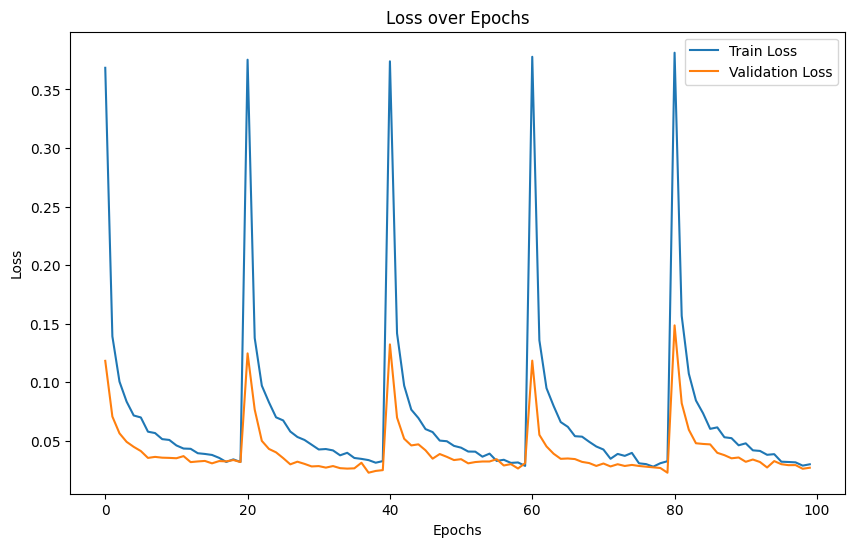

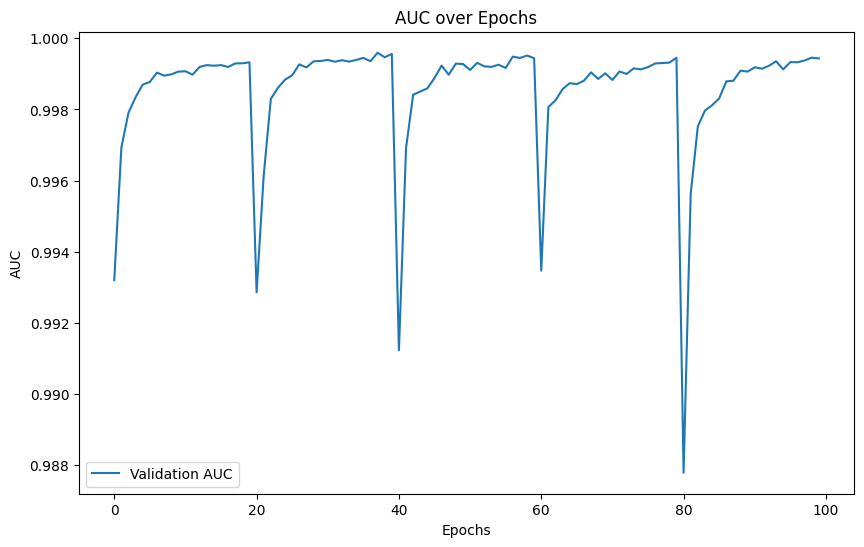

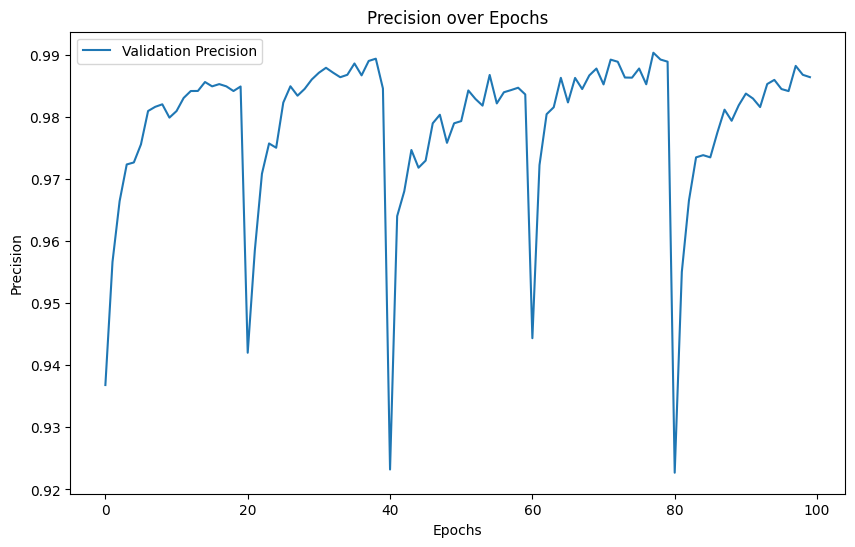

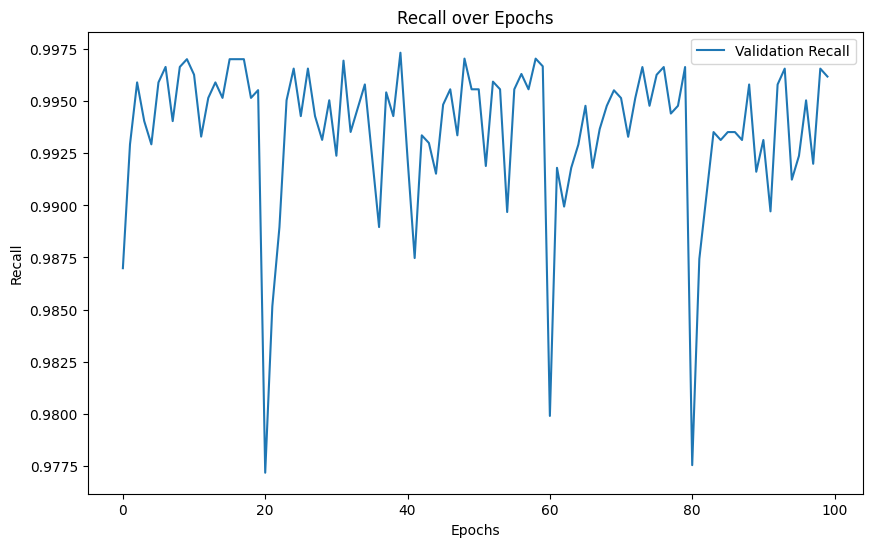

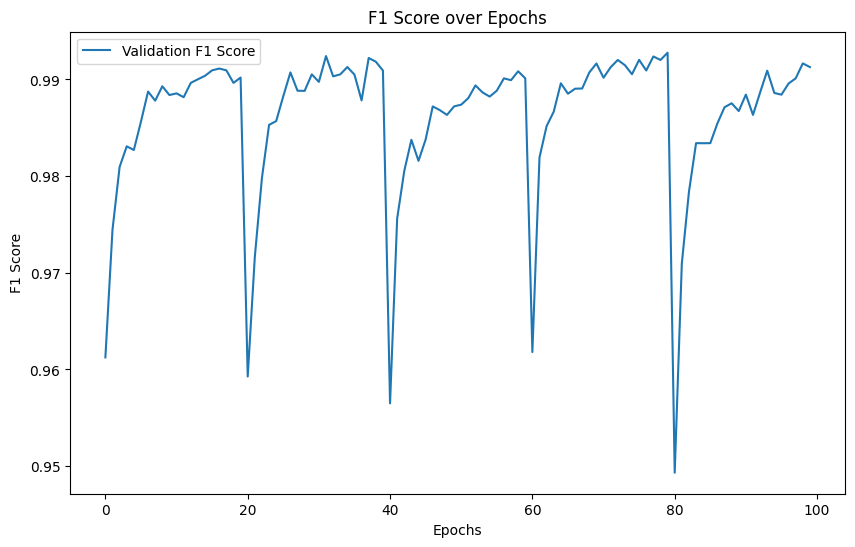

In [30]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_history["train_loss"], label='Train Loss')
plt.plot(metrics_history["val_loss"], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot AUC over epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_history["val_auc"], label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Plot Precision over epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_history["val_precision"], label='Validation Precision')
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot Recall over epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_history["val_recall"], label='Validation Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot F1 Score over epochs
plt.figure(figsize=(10, 6))
plt.plot(metrics_history["val_f1"], label='Validation F1 Score')
plt.title('F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


In [69]:
# # Check if there are common indices between train/val and test sets
# common_indices = set(tp_s_test_df.index).intersection(tp_s_train_val_df.index)
# if common_indices:
#     print("Data leakage detected!")
# else:
#     print("No data leakage found.")


In [70]:
# num_epochs = 20
# model.train()
# for epoch in range(num_epochs):
#     total_loss = 0
#     for p_features, s_features, labels, _, _ in train_loader:  # Ignore protein and substrate indices by using '_'
#         # Move data to the same device as the model
#         p_features, s_features, labels = p_features.to(device), s_features.to(device), labels.to(device)

#         # Zero the gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(p_features, s_features)

#         # Compute the loss
#         loss = criterion(outputs.squeeze(), labels)  # Use squeeze to align output and label dimensions
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         # Track the total loss
#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_loader)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


In [ ]:
# from sklearn.metrics import roc_auc_score

# def evaluate(model, loader):
#     model.eval()  # Set model to evaluation mode
#     total_loss = 0
#     all_outputs = []
#     all_labels = []

#     with torch.no_grad():  # Disable gradient computation for evaluation
#         for p_features, s_features, labels, in loader:  # Ignore protein and substrate indices
#             p_features, s_features, labels = p_features.to(device), s_features.to(device), labels.to(device)

#             # Forward pass
#             outputs = model(p_features, s_features)

#             # Compute loss
#             loss = criterion(outputs.squeeze(), labels)
#             total_loss += loss.item()

#             # Collect outputs and labels for AUC calculation
#             all_outputs.append(torch.sigmoid(outputs).cpu().numpy())  # Sigmoid to convert logits to probabilities
#             all_labels.append(labels.cpu().numpy())

#     avg_loss = total_loss / len(loader)

#     # Flatten the list of arrays into a single array
#     all_outputs = np.concatenate(all_outputs)
#     all_labels = np.concatenate(all_labels)

#     # Calculate AUC score
#     auc = roc_auc_score(all_labels, all_outputs)

#     return avg_loss, auc

# # Example usage for validation or testing
# val_loss, val_auc = evaluate(model, val_loader)
# print(f'Validation Loss: {val_loss:.4f}, Validation AUC: {val_auc:.4f}')


In [29]:
# # Load your external test set
# test_protein_indices = torch.tensor(tp_s_test_df['source'].values, dtype=torch.long).to(p_features_tensor.device)
# test_substrate_indices = torch.tensor(tp_s_test_df['target'].values, dtype=torch.long).to(s_features_tensor.device)

# test_p_features_tensor_mapped = p_features_tensor[test_protein_indices]
# test_s_features_tensor_mapped = s_features_tensor[test_substrate_indices]

# test_labels_tensor = torch.tensor(tp_s_test_df['label'].values, dtype=torch.float32).to(p_features_tensor.device)

# # Create a TensorDataset for the test set
# test_dataset = TensorDataset(test_p_features_tensor_mapped, test_s_features_tensor_mapped, test_labels_tensor)

# # Create DataLoader for the test set
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Evaluate on the test set (from tp_s_test_df)
# test_loss, test_auc = evaluate(model, test_loader)
# print(f'Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}')


In [32]:
# Evaluate on the test set (already split from tp_s_df)
test_loss, test_auc, test_precision, test_recall, test_f1 = evaluate(model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test AUC: {test_auc:.4f}')
print(f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}')


Test Loss: 0.0122, Test AUC: 0.9999
Test Precision: 0.9952, Test Recall: 0.9974, Test F1 Score: 0.9963
